In [11]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import os
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance, PointStruct

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
client = QdrantClient(url="http://localhost:6333")

In [14]:
MODEL_DIR = "./models/dinov2-base"

In [15]:
collection_name = "plant_diseases_image_collection"

if client.collection_exists(collection_name):
    client.delete_collection(collection_name)
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

True

In [ ]:
#load the model and processor
processor = AutoImageProcessor.from_pretrained(MODEL_DIR, use_fast=True)
model = AutoModel.from_pretrained(MODEL_DIR).to(device)

In [17]:
print(f"Model expected output dimension: {model.config.hidden_size}")

Model expected output dimension: 768


In [18]:
#Populate the images variable with all the images in the dataset folder
images = []
for root, dirs, files in os.walk('./data/PlantVillage-Dataset-Sample'):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')): 
            images.append(os.path.join(root, file)) 

print(f"Found {len(images)} images in total")

Found 380 images in total


In [19]:
def add_vector_to_qdrant(embedding, image_path, idx):
    """Enhanced vector addition with error handling and validation"""
    try:
        vector = embedding.detach().cpu().numpy().astype(np.float32).flatten()
        
        # Validate vector shape
        if vector.shape[0] != 768:  # DINOv2 base model outputs 768-dimensional vectors
            raise ValueError(f"Unexpected vector shape: {vector.shape}")
        
        point = PointStruct(
            id=idx,
            vector=vector.tolist(),
            payload={
                "image_path": image_path,
                "class_name": os.path.basename(os.path.dirname(image_path))  # Extract class from path
            }
        )
        
        client.upsert(
            collection_name=collection_name,
            wait=True,
            points=[point]
        )
    except Exception as e:
        print(f"Failed to index {image_path}: {str(e)}")

In [20]:
import time

In [21]:
# Indexing with progress feedback
t0 = time.time()
total_images = len(images)
for idx, image_path in enumerate(images):
    try:
        img = Image.open(image_path).convert('RGB')
        with torch.no_grad():
            inputs = processor(images=img, return_tensors="pt").to(device)
            outputs = model(**inputs)
        add_vector_to_qdrant(outputs.last_hidden_state.mean(dim=1), image_path, idx)
        
        # Print progress every 100 images
        if idx % 100 == 0:
            print(f"Processed {idx}/{total_images} images")
    except Exception as e:
        print(f"Skipping {image_path} due to error: {str(e)}")

print(f'Extraction and indexing completed in: {time.time()-t0:.2f} seconds')
print(f'Successfully indexed {len(images)} images')

Processed 0/380 images
Processed 100/380 images
Processed 200/380 images
Processed 300/380 images
Extraction and indexing completed in: 13.22 seconds
Successfully indexed 380 images


In [22]:
from qdrant_client.models import Filter, FieldCondition, MatchValue

In [26]:
image = Image.open('applescab.jpg').convert('RGB')

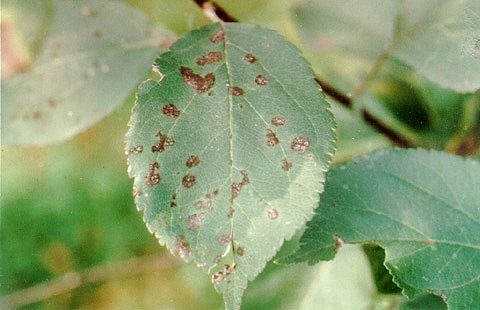

In [27]:
image

In [ ]:
# Extract features
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    query_vector = embeddings.detach().cpu().numpy().flatten().tolist()

# Perform similarity search
search_results = client.query_points(
    collection_name=collection_name,
    query=query_vector,
    limit=3,  # Top 3 results
    with_payload=True,  # Return the stored metadata
    with_vectors=False  # Don't return vectors in results
)

Top 3 similar images:

Result 1:
Score: 0.7760327
Image path: ./data/PlantVillage-Dataset-Sample/Apple___Apple_scab/b84c8919-1f8c-4751-a759-e0ec84839020___FREC_Scab 3264.JPG
Class: Apple___Apple_scab

Result 2:
Score: 0.77320147
Image path: ./data/PlantVillage-Dataset-Sample/Apple___Black_rot/ff4e792b-14c5-41db-af9e-0676abf8d20a___JR_FrgE.S 3088.JPG
Class: Apple___Black_rot

Result 3:
Score: 0.7730119
Image path: ./data/PlantVillage-Dataset-Sample/Apple___Apple_scab/2d4c8a12-a34c-4c8b-b357-271d87532ece___FREC_Scab 3090.JPG
Class: Apple___Apple_scab


Top 3 similar images:

Result 1:
Score: 0.2240
Image path: ./data/PlantVillage-Dataset-Sample/Apple___Apple_scab/b84c8919-1f8c-4751-a759-e0ec84839020___FREC_Scab 3264.JPG
Class: Apple___Apple_scab


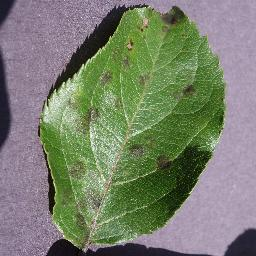


Result 2:
Score: 0.2268
Image path: ./data/PlantVillage-Dataset-Sample/Apple___Black_rot/ff4e792b-14c5-41db-af9e-0676abf8d20a___JR_FrgE.S 3088.JPG
Class: Apple___Black_rot


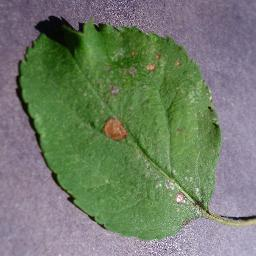


Result 3:
Score: 0.2270
Image path: ./data/PlantVillage-Dataset-Sample/Apple___Apple_scab/2d4c8a12-a34c-4c8b-b357-271d87532ece___FREC_Scab 3090.JPG
Class: Apple___Apple_scab


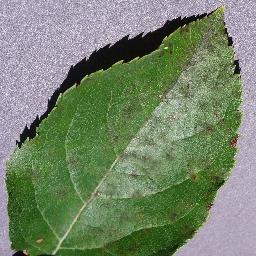

In [ ]:
from IPython.display import Image as IPyImage, display

print("Top 3 similar images:")
for i, result in enumerate(search_results.points):
    print(f"\nResult {i+1}:")
    print(f"Score: {result.score}")
    print(f"Image path: {result.payload['image_path']}")
    print(f"Class: {result.payload['class_name']}")
    display(IPyImage(filename=result.payload['image_path']))